# Libraries and preparation

refs:
- https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev

MAP:REDUCE: https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

In [1]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Downloading ollama...
######################################################################## 100.0%#=#=#                                                                          
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [2]:
def start_ollama():
    t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
    t.start()

In [3]:
def pull_model(local_llm):
    !ollama pull local_llm

In [4]:
def start_model(local_llm):        
    t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", local_llm]),daemon=True)
    t2.start()

In [5]:
%%capture --no-stderr
%pip install -U langchain-ai21 ragas langchain-pinecone langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local] langchain-text-splitters

In [6]:
# Tracing and api-keys
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["TAVILY_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["PINECONE_API_KEY"] = "94ef7896-1fae-44d3-b8d2-0bd6f5f664f5"
os.environ["AI21_API_KEY"] = "KlINkh5QKw3hG1b5Hr75YDO7TwGoQvzn"

Bias detection model:

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

bias_model_tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
bias_model = AutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model",from_tf=True)

2024-08-07 06:35:28.718867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 06:35:28.719049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 06:35:28.996758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


- https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/text_entailment/Textual%20Entailment%20Explanation%20Demo.html
- https://huggingface.co/facebook/bart-large-mnli

Entailment model (BART):

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = 0 if torch.cuda.is_available() else -1

bart_model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli",device=device)
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
def BART_prediction(premise,hypothesis):
    #print(f"Premise: {premise}")
    #print(f"Hypo: {hypothesis}")
    input_ids = bart_tokenizer.encode(premise, hypothesis, return_tensors="pt")
    logits = bart_model(input_ids)[0]
    probs = logits.softmax(dim=1)

    max_index = torch.argmax(probs).item()

    bart_label_map = {0: "contradiction", 1: "neutral", 2: "entailment"}
    return bart_label_map[max_index]

# Tools

refs:
- https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/

In [10]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=2)

# Indexing

Organizing external sources for the llm. Phase of indexing and chunking of docs refs:
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/
- https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/
- Nomic embeddings: https://docs.nomic.ai/atlas/capabilities/embeddings#selecting-a-device

osservazione: si possono controllare gli indici direttamente da https://app.pinecone.io/organizations/-O2Tiw_0VD7HTOASPJE5/projects/2a95c518-e514-4d39-bed8-4b12fd90ad44/indexes

osservazione sul chuncking: https://dev.to/peterabel/what-chunk-size-and-chunk-overlap-should-you-use-4338

In [33]:
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings

def create_retriever(index_name,top_k):
    vectorstore = PineconeVectorStore(
        index_name=index_name,
        embedding=AI21Embeddings(device="cuda")
    )
    return vectorstore.as_retriever(search_kwargs={"k": top_k})

def create_KBT_retrievers(aspects,top_k):
    retrievers = []
    for aspect in aspects:
        retriever = create_retriever(f"{aspect.lower()}-kbt",top_k)
        retrievers.append(retriever)
    return retrievers

# Query generation (multi-aspects)

In [12]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def query_generator(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to generate multiple
        search queries based on some specified aspects. You have to generate an answer as a Python list,
        and in each position of the list there is the generated query of the aspect. NO PREAMBLE: return only the list.
        Here some examples:
        Original query: "What about COVID19?"
        Aspects: ["Health","Economy"]
        Answer: ["Symptoms of COVID19","Economic consequences of COVID19"]
        \n ----- \n
        Original query: "COVID19 was fake?"
        Aspects: ["Health","Society"]
        Answer: ["Is COVID19 just a cold?","What do people think about COVID19?"]
        \n ----- \n
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Original query: {original_query}
        Aspects: {aspects}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["aspects","original_query"],
    )
    llm = ChatOllama(model=local_llm, temperature=0) 
    query_generator = prompt | llm | StrOutputParser() 
    return query_generator


#original_query = "Covid19 was a hoax?"
#aspects = ["Health","Economy"]
#generation = query_generator(local_llm).invoke({"original_query": original_query, "aspects":aspects})
#print(eval(generation))


# # Reciprocal Rank Fusion algorithm
# def reciprocal_rank_fusion(search_results_dict, k=60):
#     fused_scores = {}
#     print("Initial individual search result ranks:")
#     for query, doc_scores in search_results_dict.items():
#         print(f"For query '{query}': {doc_scores}")

#     for query, doc_scores in search_results_dict.items():
#         for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
#             if doc not in fused_scores:
#                 fused_scores[doc] = 0
#             previous_score = fused_scores[doc]
#             fused_scores[doc] += 1 / (rank + k)
#             print(f"Updating score for {doc} from {previous_score} to {fused_scores[doc]} based on rank {rank} in query '{query}'")

#     reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
#     print("Final reranked results:", reranked_results)
#     return reranked_results

# Organizing outputs

In [13]:
def final_answer(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
        You are an helpful assistant who must organize a coherent speech that comes from multiple sources. 
        Your job is to put these pieces of text together, maintaining correct punctuation and coherence in your speech. 
        Provide only the organized segments, without the preamble.
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are pieces of text: {answers}
        Result answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["answers"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    final_answer = prompt | llm | StrOutputParser()
    return final_answer

#final_output = final_answer.invoke({"answers": answers})
#print(final_output)

# Retrieval

In [14]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

#higher temperature more likely hallucinations

def retrieval_grader(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
        of a retrieved document to a user question. If the document contains keywords related to the user question,
        grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide only the answer 'yes' or 'no', NOT ANYMORE. NO PREAMBLE. NO EXPLANATION.
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here is the retrieved document: \n\n {document} \n\n
        Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """,
        input_variables=["question", "document"],
    )
    llm = ChatOllama(model=local_llm, temperature=0) #higher temperature more likely hallucinations
    retrieval_grader = prompt | llm | StrOutputParser()
    return retrieval_grader

# question = "agent memory"
# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

# Generating answer

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_chain(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
        Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
        Question: {question}
        Context: {context}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "document"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    return rag_chain

# Run
# question = "agent memory"
# docs = retriever.invoke(question)
# generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

# Hallucinations check (not used)

Per ora non uso hallucinations check

In [16]:
def hallucination_grader(local_llm):
    prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' (both in lower case) to indicate
        whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
        SINGLE KEY 'score' and NO preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are the facts:
        \n ------- \n
        {documents}
        \n ------- \n
        Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "documents"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    hallucination_grader = prompt | llm | JsonOutputParser()
    return hallucination_grader

#hallucination_grader.invoke({"documents": docs, "generation": generation})

# Answer check

In [17]:
def answer_grader(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
        answer is useful to resolve a question. Give a binary score 'yes' or 'no' (both in lower case) to indicate whether the answer is
        useful to resolve a question. Provide the binary score as a JSON with a SINGLE KEY 'score' and NO preamble or explanation.
         <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
        \n ------- \n
        {generation}
        \n ------- \n
        Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "question"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    answer_grader = prompt | llm | JsonOutputParser()
    return answer_grader

#answer_grader.invoke({"question": question, "generation": generation})

# Routing (not used)

Per ora non applichiamo il routing!

In [18]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def question_router(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
        user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
        prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
        in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
        or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
        no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    question_router = prompt | llm | JsonOutputParser()
    return question_router
    
# question = "llm agent memory"
# docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content
# print(question_router.invoke({"question": question}))

# Document check (Entailment)

In [19]:
def entailment_checker(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to perform a task of textual entailments
        between two documents. Give three category 'contradiction','neutral' or 'entailment' (all in lower case).
        Two documents are in 'contradiction', if there are contradicting statements.
        There is an 'entailment' between first document and second document if it is likely that from the first document I can deduce what is stated in the second document. 
        Two documents are 'neutral' if they are not in contradiction or in entailment.
        Provide only the answer with the category, NOT ANYMORE. NO PREAMBLE. NO EXPLANATION.
         <|eot_id|><|start_header_id|>user<|end_header_id|> First document:
        {first_doc}
        \n ------- \n
        Second document:
        \n ------- \n
        {second_doc}
        \n ------- \n
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["first_doc", "second_doc"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    entailment_checker = prompt | llm | StrOutputParser()
    return entailment_checker

# Debiasing

https://learnprompting.org/docs/reliability/debiasing

In [20]:
def debiasing_answer(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> The user will pass you text cointaining biases.
        Your role is to give a debiased version of the text. Give ONLY the debiased text, NO PREAMBLE, NO EXPLANATIONS.
        Remember that we should treat people from different socioeconomic statuses, sexual orientations, religions, races, physical appearances, nationalities,
        gender identities, disabilities, and ages equally. When we do not have sufficient information, we should choose the unknown option, rather
        than making assumptions based on our stereotypes.
         <|eot_id|><|start_header_id|>user<|end_header_id|> 
        {text}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["text"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    debiasing = prompt | llm | StrOutputParser()
    return debiasing

# Hate speech detection

https://arxiv.org/html/2401.03346v1/#S4

In [21]:
def hate_speech_detection(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an helpful assistant who has to detect the presence of hate speech.
            Hate speech is speech that attacks a person or group based on attributes such as race, religion, ethnic origin, national origin, sex, disability, sexual orientation, or gender identity. 
            You have to answer "yes" if it contains hate speech, or "no" if it doesn't contain hate speech. NO PREAMBLE, NO EXPLANATIONS.
            <|eot_id|><|start_header_id|>user<|end_header_id|> 
            Do you think this document contain hate speech? document: {document}.
            <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["document"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    hate_speech_detection = prompt | llm | StrOutputParser()
    return hate_speech_detection

# Aspect agents

refs
- https://www.langchain.com/langgraph

In [25]:
from pprint import pprint
from typing import List, Annotated
import operator
import functools

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State
class GraphState(TypedDict):
    """
    Represents the state of graph of aspect agents.
    """
    
    query: str
    aspect_id: int
    answers_agent: Annotated[List[str], operator.add]
    my_answer: str
    web_search: str
    documents: List[str]
    documents_kbt: List[str]


def retrieve(state,verbose,retriever,retrievers_KBT):
    """
    Retrieve documents from vectorstore and from KBT

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if verbose: 
        print("---RETRIEVE---")
        print(f"State: {state}")
        
    query = state["query"]
    aspect_id = state["aspect_id"]

    # Retrieval
    documents = retriever.invoke(query)
    documents_kbt = retrievers_KBT[aspect_id].invoke(query)
    
    #pprint(f"Documents retrieved: {documents}")
    #pprint(f"Documents KBT retrieved: {documents_kbt}")
    
    return {"documents": documents, "documents_kbt": documents_kbt, "query": query}


def generate(state,verbose,llm,fairness):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if verbose:
        print("---GENERATE---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain(llm).invoke({"context": documents, "question": query})
    aspect_id = state["aspect_id"]
    print(f"Aspect agent {aspect_id} generates: {generation}")
    if fairness:
        return {"documents": documents, "query": query, "my_answer": generation}
    return {"documents": documents, "query": query, "my_answer": generation, "answers_agent": [generation]}

def confirm_answer(state,verbose):
    """
    Confirm answer if there is no bias in the text.

    Args:
        state (dict): The current graph state

    """
    if verbose:
        print("---CONFIRM ANSWER---")
        print(f"State: {state}")
    my_answer = state["my_answer"]

    return {"answers_agent": [my_answer]}


def grade_documents(state,verbose,llm):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    if verbose:
        print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader(llm).invoke(
            {"question": query, "document": d.page_content}
        )
        #grade = score["score"]
        # Document relevant
        if score.lower() == "yes":
            if verbose: print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            if verbose: print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "query": query, "web_search": web_search}


def web_search(state,verbose):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """
    if verbose:
        print("---WEB SEARCH---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )

    doc_splits = text_splitter.split_documents([web_results])
    for doc in doc_splits:
        if documents is None:
            documents = [doc]
        else:
            documents.append(doc)
    return {"documents": documents, "query": query}


def hate_speech_filter(state,verbose,llm):
    if verbose:
        print("---HATE SPEECH FILTER---")
        print(f"State: {state}")
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = hate_speech_detection(llm).invoke(
            {"document": d.page_content}
        )
        #grade = score["score"]
        if score.lower() == "no":
            if verbose: print("---DOCUMENT ACCEPTED---")
            filtered_docs.append(d)
    
    return {"documents": filtered_docs}


def entailment_filter(state,BART_model,strategy_entailment,neutral_acceptance,verbose,test_mode,observer,llm):
    """
    Filter documents that doesn't entail with KBT

    Args:
        state (dict): The current graph state
    """
    
    if verbose:
        print("---ENTAILMENT FILTER---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    documents_KBT = state["documents_kbt"]

    # Score each doc
    filtered_docs = []
    if strategy_entailment: #Skeptical
        for d in documents:
            neutral = True
            for d_kbt in documents:
                if BART_model:
                    score = BART_prediction(d_kbt.page_content,d.page_content)
                else:
                    score = entailment_checker(llm).invoke(
                        {"first_doc": d_kbt.page_content, "second_doc": d.page_content}
                    )
                #grade = score["score"]
                # Document entailed
                if score.lower() != "neutral":
                    neutral = False
                if score.lower() == "contradiction":
                    # contradiction found
                    break
            if not neutral or neutral_acceptance:
                filtered_docs.append(d)
                if verbose: print("---DOCUMENT ENTAILED---")   
    else: #Credolous
        for d in documents:
            neutral = True
            for d_kbt in documents:
                if BART_model:
                    score = BART_prediction(d_kbt.page_content,d.page_content)
                else:
                    score = entailment_checker(llm).invoke(
                        {"first_doc": d_kbt.page_content, "second_doc": d.page_content}
                    )
                #grade = score["score"]
                # Document entailed
                if score.lower() != "neutral":
                    neutral = False
                if score.lower() == "entailment":
                    if verbose: print("---DOCUMENT ENTAILED---")
                    filtered_docs.append(d)
                    break
            if neutral and neutral_acceptance:
                filtered_docs.append(d)
                if verbose: print("---DOCUMENT ENTAILED---")
    
    if test_mode:
        #todo misura metriche con sklearn classifier
        #0 tweet veri, #1 tweet falsi
        y_true = [document.metadata.get("label") for document in documents]
        y_pred = [0 if document in filtered_docs else 1 for document in documents]
        report = sklearn.metrics.classification_report(y_true,y_pred,labels=[0,1])
        my_dict = {"query": query, "report": report}
        observer.set_generated_queries(my_dict)
    return {"documents": filtered_docs}


def debiasing(state,verbose,llm):
    if verbose:
        print("---DEBIASING FILTER---")
        print(f"State: {state}")
        
    answer = state["my_answer"]
    
    unbiased_answer = debiasing_answer(llm).invoke({"text": answer})
    
    return {"answers_agent": [unbiased_answer]}


### Conditional edge

def bias_detection(state,verbose):
    if verbose:
        print("---BIAS DETECTION---")
        print(f"State: {state}")
        
    answer = state["my_answer"]
    
    bias_detection = pipeline('text-classification', model=bias_model, tokenizer=bias_model_tokenizer, device=device) # cuda = 0,1 based on gpu availability
    answer = bias_detection(answer)
    if verbose: print(answer[0]['label']) #Biased, Non-biased
    
    return answer[0]['label']

    
#Not used
def route_question(state,verbose,llm):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    if verbose:
        print("---ROUTE QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    #print(queries)
    source = question_router(llm).invoke({"question": query})
    #print(source)
    #print(source["datasource"])
    if source["datasource"] == "web_search":
        if verbose: print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        if verbose: print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state,verbose):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    if verbose:
        print("---ASSESS GRADED DOCUMENTS---")
        print(f"State: {state}")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        if verbose: print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
            )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        if verbose: print("---DECISION: RELEVANT---")
        return "relevant"


# Not used
def grade_generation_v_documents_and_question(state,verbose,llm):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    
    if verbose:
        print("---CHECK HALLUCINATIONS---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    my_answer = state["my_answer"]

    score = hallucination_grader(llm).invoke(
        {"documents": documents, "generation": my_answer} #answers_agent[0]
    )
    if verbose: print(f"score: {score}")
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        if verbose: print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        if verbose: print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": query, "generation": my_answer})
        grade = score["score"]
        if grade == "yes":
            if verbose: print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if verbose: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        if verbose: pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

**Building graph with edges**

In [26]:
# Workflow condizionale
def workflow_aspect_agent(configs):
    # Build graph
    workflow = StateGraph(GraphState)

    workflow.add_node("retrieve", functools.partial(retrieve, verbose=configs.verbose, 
                                                    retriever=configs.retriever, retrievers_KBT=configs.retrievers_KBT))  # retrieve
    workflow.add_node("generate", functools.partial(generate, verbose=configs.verbose, 
                                                    llm=configs.local_llm, fairness=configs.fairness))  # generatae
    
    if configs.web_search:
        workflow.add_node("websearch", functools.partial(web_search, verbose=configs.verbose))  # web search
        workflow.add_node("grade_documents", functools.partial(grade_documents, verbose=configs.verbose, 
                                                               llm=configs.local_llm))  # grade documents
    if configs.safeness:
        workflow.add_node("hate_speech_filter", functools.partial(hate_speech_filter, verbose=configs.verbose, 
                                                                  llm=configs.local_llm))
    if configs.trustworthiness:
        workflow.add_node("entailment_filter", functools.partial(entailment_filter, BART_model=configs.BART_model, strategy_entailment=configs.strategy_entailment, 
                                                                 neutral_acceptance=configs.neutral_acceptance, verbose=configs.verbose, llm=configs.local_llm, 
                                                                 test_mode=configs.test_mode, observer=configs.observer))  # entailment
    if configs.fairness:  
        workflow.add_node("debiasing_filter", functools.partial(debiasing, verbose=configs.verbose, llm=configs.local_llm))
        workflow.add_node("confirm_answer", functools.partial(confirm_answer, verbose=configs.verbose))

    # Non applichiamo il routing
    """
    workflow.add_conditional_edges(
        START,
        route_question,
        {
            "websearch": "websearch", #se la risposta è websearch, allora vai al nodo websearch
            "vectorstore": "retrieve", #se la risposta è vectorstore, allora vai al nodo retrieve
        },
    )
    """
    
    workflow.add_edge(START, "retrieve")
    
    if configs.web_search:
        workflow.add_edge("retrieve", "grade_documents")  
        workflow.add_conditional_edges(
            "grade_documents",
            functools.partial(decide_to_generate, verbose=configs.verbose),
            {
                "websearch": "websearch",
                "relevant": "hate_speech_filter" if configs.safeness else "entailment_filter" if configs.trustworthiness else "generate"
            },
        )
    
    if configs.safeness:
        if configs.web_search:
            workflow.add_edge("websearch", "hate_speech_filter")
        else: 
            workflow.add_edge("retrieve", "hate_speech_filter")
        if configs.trustworthiness:
            workflow.add_edge("hate_speech_filter", "entailment_filter")
            workflow.add_edge("entailment_filter", "generate")
        else:
            workflow.add_edge("hate_speech_filter","generate")
    elif configs.trustworthiness:
        if configs.web_search:
            workflow.add_edge("websearch", "entailment_filter")
        else: 
            workflow.add_edge("retrieve", "entailment_filter")
        workflow.add_edge("entailment_filter", "generate")
    else:
        if configs.web_search:
            workflow.add_edge("websearch", "generate")
        else: 
            workflow.add_edge("retrieve", "generate")
    
    if configs.fairness:
        workflow.add_conditional_edges(
            "generate",
            functools.partial(bias_detection, verbose=configs.verbose),
            {
                "Biased": "debiasing_filter",
                "Non-biased": "confirm_answer",
            },
        )
        workflow.add_edge("confirm_answer", END)
        workflow.add_edge("debiasing_filter", END)
    else:
        workflow.add_edge("generate", END)

    # Non faccio il controllo sulle allucinazioni
    """
    workflow.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "websearch",
        },
    )
    """    
    workflow_compiled = workflow.compile()
    return workflow_compiled

In [27]:
from IPython.display import Image, display

display(Image(workflow_aspect_agent(configs).get_graph().draw_mermaid_png()))

NameError: name 'configs' is not defined

# Master agent

In [28]:
from typing import Annotated
import operator
from langgraph.constants import Send


### Super Graph State
class SuperGraphState(TypedDict):
    """
    Represents the state of our super-graph.
    """
    
    question: str
    aspects: List[str]
    queries: List[str]
    answers_agent: Annotated[List[str], operator.add]
    final_answer: str


def generate_queries(state,verbose,llm):
    """
    Generate multi-aspect queries from the starting question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the multi aspect queries
    """
    if verbose: 
        print("---GENERATE MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    question = state["question"]
    aspects = state["aspects"]

    generation = query_generator(llm).invoke({"original_query": question, "aspects": aspects})
    #print(list(generation.values()))
    return {"queries": eval(generation)}

def send_queries(state,verbose):
    if verbose: 
        print("---SEND MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    return [Send("aspect_agent_node", {"query": q, "aspect_id": state["queries"].index(q)}) for q in state["queries"]]

def organize_answers(state,verbose,llm):
    """
    Organize the outputs of the agents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains the final answer to give to user
    """
    if verbose:
        print("---ORGANIZE OUTPUTS---")
        print(f"State: {state}")
    answers_agent = state["answers_agent"]
    
    print(f"I'm the master agent and I received: {answers_agent}")

    final_output =final_answer(llm).invoke({"answers": answers_agent})
    return {"final_answer": final_output}

In [29]:
def master_flow(configs):
    master_flow = StateGraph(SuperGraphState)

    # Define the nodes
    master_flow.add_node("generate_queries", functools.partial(generate_queries, verbose=configs.verbose, llm=configs.local_llm))
    master_flow.add_node("organize_answers", functools.partial(organize_answers, verbose=configs.verbose, llm=configs.local_llm))
    master_flow.add_node("aspect_agent_node",workflow_aspect_agent(configs))

    # Build graph
    master_flow.add_edge(START, "generate_queries")
    master_flow.add_conditional_edges("generate_queries", functools.partial(send_queries, verbose=configs.verbose), ["aspect_agent_node"])
    master_flow.add_edge("aspect_agent_node", "organize_answers")
    master_flow.add_edge("organize_answers", END)

    master_compiled = master_flow.compile()
    return master_compiled

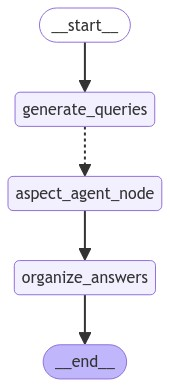

In [36]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(master_flow(configs).get_graph().draw_mermaid_png()))

# Configuration and app-launching

Vectorstore configuration

In [31]:
index_name = "entailment-test"
aspects = ["Health","Technology","Society"] #Finance #Education

top_retriever = 10 #documents retrieved by retriever
top_KBT = 5 #documents retrievede by KBT retriever

retriever = create_retriever(index_name, top_retriever)
retrievers_KBT = create_KBT_retrievers(aspects, top_KBT)

In [29]:
class Config(object):
    def __init__(self,retriever,retrievers_KBT,aspects):
        self.local_llm = "llama3.1" #"llama3.1:70b"
        
        self.retriever = retriever
        self.retrievers_KBT = retrievers_KBT
        
        self.aspects = aspects
        
        #if we want print all the process: True
        self.verbose = True 
        
        #if we want to include websearch in the workflow
        self.web_search = True

        # Controlling properties
        self.safeness = True # if we want to add hate speech detection module
        self.trustworthiness = True # if we want to add entailment module with KBT
        self.fairness = True  # if we want to add debiasing module.

        #Controlling entailment
        # strategy for the entailment, False = "Credolous", True = "Skeptical" 
        self.strategy_entailment = True

        #manage the total neutral entailed documents (what if a document is neutral with all documents of KBT)
        # True = accept the neutral documents, False = don't accept
        self.neutral_acceptance = True
        
        # True: uses BART model for the entailment, False: uses LLM
        self.BART_model = True
        
        # For testing
        self.test_mode = False
        self.observer = None
    
    def add_observer(observer):
        self.observer = observer
    
configs = Config(retriever,retrievers_KBT,aspects)

Starting language model

In [ ]:
start_ollama()
pull_model(configs.local_llm)
start_model(configs.local_llm)

In [ ]:
inputs = {"question": "Covid19 was a hoax?", "aspects": configs.aspects}

for output in master_flow(configs).stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
answer = value["final_answer"]
print(answer)

# Test

In [ ]:
# Funzioni di supporto:

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)
    
queries_gpt = []

# Scrittura query in un file json:
def queries_in_json(queries):
    dict_query = {}
    for query in queries:
        dict_query['query'] = query
    write_file("/kaggle/output/preference/gpt_queries.json",dict_query)

def load_queries(filename):
    queries = []
    json_file = load_json(filename)
    
    for item in json_file:
        dictionary = dict(item.items())
        queries.append(dictionary['query'])

Predisposizione dell'observer per salvare i risultati

In [ ]:
class Observer(object):
    def __init__(self):
        self.query=""
        self.type_of_acceptance=""
        self.neutral_acceptance=False
        self.generated_queries={}
        self.final_answer=""
    
    def set_query(query):
        self.query=query
    
    def set_type_of_acceptance(type_of_acceptance):
        self.type_of_acceptance=type_of_acceptance
    
    def set_neutral_acceptance(neutral_acceptance):
        self.neutral_acceptance=neutral_acceptance
        
    def set_generated_queries(result_query):
        self.generated_queries.update(result_query)
        
    def set_final_answer(final_answer):
        self.final_answer=final_answer
    
    def generate_dict():
        return {"query": self_query,
               "type_of_acceptance": type_of_acceptance,
               "neutral_acceptance": neutral_acceptance,
               "generated_queries": generated_queries,
               "final_answer": final_answer}

Test su lista di query

In [ ]:
queries_list = load_queries("/kaggle/input/preference/gpt_queries.json")

attempt = 1
ret_dict = {}
for query in queries_list:
    inputs = {"question": query, "aspects": configs.aspects}
    
    configs.add_observer(Observer())
    configs.observer.set_query(query)
    if configs.strategy_entailment:
        configs.observer.set_type_of_acceptance("Skeptical")
    else:
        configs.observer.set_type_of_acceptance("Credulous")
    configs.observer.set_neutral_acceptance(configs.neutral_acceptance)

    for output in master_flow(configs).stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
    answer = value["final_answer"]
    
    configs.observer.set_final_answer(final_answer)
    ret_dict[f"attempt {attempt}"] = configs.observer.generate_dict()
    
    attempt = attempt + 1

write_file("/kaggle/output/preference/test_results.json",ret_dict)

# Evaluation

## Entailment evaluation

## Debiasing evaluation

## Hate speech evaluation

# Ragas (application evaluation)

https://docs.ragas.io/en/stable/

In [ ]:
#todo